In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, RandomSampler

from sklearn.metrics import accuracy_score, f1_score

import numpy as np
import pandas as pd
from tqdm import tqdm

import random
import time

from dataset import CSICDataset, Vocab

In [2]:
# Defining global constants
RANDOM_SEED = 42
BATCH_SIZE = 64

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
# This is how we select a GPU if it's available on your computer or in the Colab environment.
print('Device of execution - ', device)

Device of execution -  mps


In [4]:
df = pd.read_csv('./dataset/dataset.csv')
df = CSICDataset.process_df(df)

# The following two lines are used to load the indices of the training and validation sets
train_indices = np.load('./dataset/train_indices.npy')
val_indices = np.load('./dataset/val_indices.npy')

# The following two lines are used to select the training and validation sets from the dataframe based on the indices loaded above
train_data = df.loc[train_indices].reset_index(drop=True)
val_data = df.loc[val_indices].reset_index(drop=True)

In [5]:
train_dataset = CSICDataset(df=train_data, vocab_size=5000, min_frequency=1, tokenization_algorithm='bpe')
train_vocab = train_dataset.vocab

val_dataset = CSICDataset(df=val_data, vocab=train_vocab)

train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)

In [184]:
len(train_vocab)

5000

In [ ]:
# Check Dataset Lengths
assert len(train_dataset) == 45319, "Training Dataset is of incorrect size"
assert len(val_dataset) == 11330, "Validation Dataset is of incorrect size"

print('Training and Validation dataset sizes match!')

Training and Validation dataset sizes match!


In [6]:
PADDING_VALUE = train_vocab.pad_id

In [7]:
def collate_fn(batch, padding_value=PADDING_VALUE):
    # Batch is of the form List[Tuple(Features(tokenized_ids,...), Labels)]
    sequences = [torch.tensor(sample[0]['tokenized_ids'], dtype=torch.long, device=device) for sample in batch]
    padded_tokens = torch.nn.utils.rnn.pad_sequence(sequences=sequences,batch_first=True, padding_value=padding_value)
    
    labels = torch.tensor([sample[1] for sample in batch])

    return padded_tokens, labels

In [8]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)

In [9]:
for x, y in train_iterator:
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')
    break

x: torch.Size([64, 199])
y: torch.Size([64])


In [10]:
class RecurrentWAF(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rec_hidden_size, fc_hidden_size, recurrent_type='LSTM', dropout=None):
        super(RecurrentWAF, self).__init__()
        
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=PADDING_VALUE)
        
        match recurrent_type:
            case 'LSTM':
                self.recurrent = nn.LSTM(input_size=embedding_dim, hidden_size=rec_hidden_size, batch_first=True)
            case 'RNN':
                self.recurrent = nn.RNN(input_size=embedding_dim, hidden_size=rec_hidden_size, batch_first=True)
            case 'GRU':
                self.recurrent = nn.GRU(input_size=embedding_dim, hidden_size=rec_hidden_size, batch_first=True)
            
            case _:
                raise TypeError("Unsupported Recurrent Layer Type received")

        self.fc = nn.Sequential(
            nn.Linear(in_features=rec_hidden_size, out_features=fc_hidden_size, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=fc_hidden_size, out_features=1, bias=True)
        )

        self.activation = nn.Sigmoid()

        if dropout:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = None

        self.embedding_dim = embedding_dim
        self.rec_hidden_size = rec_hidden_size
        self.fc_hidden_size = fc_hidden_size
        self.recurrent_type = recurrent_type

    def forward(self, input):
        embed = self.embed_input(input)
        
        if self.recurrent_type == 'RNN' or self.recurrent_type == 'GRU':
            _, hidden = self.recurrent(embed)
        else:
            _, (hidden, cell) = self.recurrent(embed)

        hidden = hidden.squeeze(dim=0)
        out = self.activation(self.fc(hidden))

        return out
    
    def embed_input(self, input):
        if self.dropout:
            return self.dropout(self.embed(input))
        else:
            return self.embed(input)
        
    # @staticmethod
    # def load(model_path: str):
    #     params = torch.load(model_path, map_location=lambda storage, loc: storage)
    #     args = params['args']
    #     model = RecurrentWAF(vocab=params['vocab'], **args)
    #     model.load_state_dict(params['state_dict'])

    #     return model

    # def save(self, path: str):
    #     print('save model parameters to [%s]' % path, file=sys.stderr)

    #     params = {
    #         'args': dict(embed_size=self.embed_size, hidden_size=self.hidden_size, dropout_rate=self.dropout_rate,
    #                      label_smoothing=self.label_smoothing),
    #         'vocab': self.vocab,
    #         'state_dict': self.state_dict()
    #     }

    #     torch.save(params, path)

In [73]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
def get_accuracy_and_f1_score(y_true, y_predicted):
    """
    This function takes in two numpy arrays and computes the accuracy and F1 score
    between them. You can use the imported sklearn functions to do this.

    Args:
        y_true (list) : A 1D numpy array of ground truth labels
        y_predicted (list) : A 1D numpy array of predicted labels

    Returns:
        accuracy (float) : The accuracy of the predictions
        f1_score (float) : The F1 score of the predictions
    """

    # Get the accuracy
    accuracy = accuracy_score(y_true, y_predicted)

    # Get the F1 score
    f1 = f1_score(y_true, y_predicted)

    return accuracy, f1


In [46]:
def train_loop(model, criterion, optimizer, iterator):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch for all batches
    """
    # Set the model to train mode (build computation graph)
    model = model.to(device)
    model.train()
    
    total_loss = 0
    for x, y in tqdm(iterator, total=len(iterator), desc="Training Model"):

        optimizer.zero_grad()

        x, y = x.to(device), y.to(device)
        outs = model(x).squeeze(dim=-1)

        loss = criterion(outs, y.float())
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(iterator)

    return average_loss

In [12]:
def val_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    total_comp_time = 0

    # Set the model to evaluation mode
    model.eval()

    # Don't calculate gradients
    with torch.no_grad():
        for x, y in tqdm(iterator, total=len(iterator), desc="Validating Model"):
            x, y = x.to(device), y.to(device)

            start = time.time()
            outs = model(x)
            total_comp_time += time.time() - start
            
            outs = outs.squeeze(dim=-1)

            predictions = [True if out >= 0.5 else False for out in outs]
            labels = [True if label == 1 else False for label in y]

            loss = criterion(outs, y.float())
            total_loss += loss.item()

            # Add the predictions and labels to the lists
            pred.extend(predictions)
            true.extend(labels)
        average_loss = total_loss / len(iterator)
        average_comp_time = total_comp_time / len(iterator)

    return true, pred, average_loss, average_comp_time

In [15]:
# HYPERPARAMETERS:

EMBEDDING_DIM = 64
REC_HIDDEN_DIM = 64
FC_HIDDEN_DIM = 64
REC_LAYER_TYPE = 'LSTM'
DROPOUT = 0.2

BETAS = (0.9,0.999)
LR = 1e-3
EPOCHS = 10

In [16]:
model = RecurrentWAF(vocab_size=len(train_vocab),embedding_dim=EMBEDDING_DIM,
                     rec_hidden_size=REC_HIDDEN_DIM, fc_hidden_size=FC_HIDDEN_DIM,
                     recurrent_type=REC_LAYER_TYPE, dropout=DROPOUT).to(device)

In [17]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=LR, betas=BETAS)

In [280]:
for epoch in range(EPOCHS):
    train_loss = train_loop(model, criterion, optimizer, train_iterator)
    true, pred, val_loss, comp_time = val_loop(model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")

Validating Model: 100%|██████████| 178/178 [00:10<00:00, 17.30it/s]


Epoch 1 -- Train_Loss: 0.6788067474688058 -- Val_Loss: 0.6698526048593307 -- Val_Accuracy: 0.5684907325684024 -- Val_F1: 0.0


Validating Model: 100%|██████████| 178/178 [00:10<00:00, 16.72it/s]


Epoch 2 -- Train_Loss: 0.5222093330115626 -- Val_Loss: 0.32319531070717267 -- Val_Accuracy: 0.8490732568402471 -- Val_F1: 0.8474031768695341


Validating Model: 100%|██████████| 178/178 [00:11<00:00, 14.88it/s]


Epoch 3 -- Train_Loss: 0.2711113736096491 -- Val_Loss: 0.23346377653854616 -- Val_Accuracy: 0.8981465136804943 -- Val_F1: 0.893088753010932


Validating Model: 100%|██████████| 178/178 [00:10<00:00, 16.41it/s]


Epoch 4 -- Train_Loss: 0.21777642593943686 -- Val_Loss: 0.20268197470668997 -- Val_Accuracy: 0.9158870255957634 -- Val_F1: 0.910153672103328


Validating Model: 100%|██████████| 178/178 [00:12<00:00, 14.78it/s]


Epoch 5 -- Train_Loss: 0.19242034792605844 -- Val_Loss: 0.18347780429496524 -- Val_Accuracy: 0.9296557811120918 -- Val_F1: 0.9229877282829259


Validating Model: 100%|██████████| 178/178 [00:13<00:00, 13.41it/s]


Epoch 6 -- Train_Loss: 0.17809928349929904 -- Val_Loss: 0.17299216358367814 -- Val_Accuracy: 0.9340688437775816 -- Val_F1: 0.928221389449409


Validating Model: 100%|██████████| 178/178 [00:11<00:00, 15.72it/s]


Epoch 7 -- Train_Loss: 0.1665121461980686 -- Val_Loss: 0.17336161458718308 -- Val_Accuracy: 0.935657546337158 -- Val_F1: 0.9295311744804253


Validating Model: 100%|██████████| 178/178 [00:11<00:00, 15.09it/s]


Epoch 8 -- Train_Loss: 0.15426279270262241 -- Val_Loss: 0.16543016580111358 -- Val_Accuracy: 0.9379523389232127 -- Val_F1: 0.9324622922470939


Validating Model: 100%|██████████| 178/178 [00:13<00:00, 13.53it/s]


Epoch 9 -- Train_Loss: 0.14668134116792292 -- Val_Loss: 0.16401055739836745 -- Val_Accuracy: 0.9411297440423654 -- Val_F1: 0.9342403628117913


Validating Model: 100%|██████████| 178/178 [00:12<00:00, 14.73it/s]

Epoch 10 -- Train_Loss: 0.13875921815108344 -- Val_Loss: 0.15603853938996456 -- Val_Accuracy: 0.9458075904677846 -- Val_F1: 0.9402956048230261


In [167]:
torch.save(model,'./models/lstm_waf_new.bin')

In [151]:
true, pred, val_loss, comp_time = val_loop(model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")
print(f"Average Time to Compute Forward Pass: {comp_time*1000} ms")

Validating Model: 100%|██████████| 178/178 [00:15<00:00, 11.43it/s]

Final Validation Accuracy: 0.9029126213592233
Final Validation F1-Score: 0.8972154737432255


In [272]:
device = 'cpu'

In [84]:
model = torch.load('./models/lstm_waf_new.bin', map_location=device)

## Global Unstructured Pruning: ##

In [104]:
import torch.nn.utils.prune as prune

parameters_to_prune = (
    (model.recurrent, 'weight_ih_l0'),
    (model.recurrent, 'weight_hh_l0'),
    (model.recurrent, 'bias_ih_l0'),
    (model.recurrent, 'bias_hh_l0'),
    (model.fc[0], 'weight'),
    (model.fc[0], 'bias'),
    (model.fc[2], 'weight'),
    (model.fc[2], 'bias'),
)

prune.global_unstructured(
    parameters=parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.6,
)

In [105]:
# Permanently apply pruning to the model & save

prune.remove(model.recurrent, 'weight_ih_l0')
prune.remove(model.recurrent, 'weight_hh_l0')
prune.remove(model.recurrent, 'bias_ih_l0')
prune.remove(model.recurrent, 'bias_hh_l0')
prune.remove(model.fc[0], 'weight')
prune.remove(model.fc[0], 'bias')
prune.remove(model.fc[2], 'weight')
prune.remove(model.fc[2], 'bias')

torch.save(model, './models/lstm_waf_new_pruned_unstructured.bin')

Linear(in_features=64, out_features=1, bias=True)

## Local Structured Pruning: ##

In [109]:
import torch.nn.utils.prune as prune

parameters_to_prune = (
    (model.recurrent, 'weight_ih_l0'),
    (model.recurrent, 'weight_hh_l0'),
    # (model.recurrent, 'bias_ih_l0'),
    # (model.recurrent, 'bias_hh_l0'),
    (model.fc[0], 'weight'),
    # (model.fc[0], 'bias'),
    (model.fc[2], 'weight'),
    # (model.fc[2], 'bias'),
)

for module, name in parameters_to_prune:
    prune.ln_structured(
        module=module,
        name=name,
        amount=0.4,
        n=2,
        dim=1
    )
    prune.remove(module=module, name=name)

In [321]:
# Save the locally pruned model
torch.save(model, './models/lstm_waf_new_pruned_structured.bin')

## Model Sparsity After Pruning: ##

In [107]:
print(
    "Sparsity in recurrent.weight_ih_l0': {:.2f}%".format(
        100. * float(torch.sum(model.recurrent.weight_ih_l0 == 0))
        / float(model.recurrent.weight_ih_l0.nelement())
    )
)
print(
    "Sparsity in recurrent.weight_hh_l0: {:.2f}%".format(
        100. * float(torch.sum(model.recurrent.weight_hh_l0 == 0))
        / float(model.recurrent.weight_hh_l0.nelement())
    )
)
print(
    "Sparsity in recurrent.bias_ih_l0': {:.2f}%".format(
        100. * float(torch.sum(model.recurrent.bias_ih_l0 == 0))
        / float(model.recurrent.bias_ih_l0.nelement())
    )
)
print(
    "Sparsity in recurrent.bias_hh_l0: {:.2f}%".format(
        100. * float(torch.sum(model.recurrent.bias_hh_l0 == 0))
        / float(model.recurrent.bias_hh_l0.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc[0].weight == 0))
        / float(model.fc[0].weight.nelement())
    )
)
print(
    "Sparsity in fc1.bias: {:.2f}%".format(
        100. * float(torch.sum(model.fc[0].bias == 0))
        / float(model.fc[0].bias.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc[2].weight == 0))
        / float(model.fc[2].weight.nelement())
    )
)
print(
    "Sparsity in fc2.bias: {:.2f}%".format(
        100. * float(torch.sum(model.fc[2].bias == 0))
        / float(model.fc[2].bias.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model.recurrent.bias_ih_l0 == 0)
            + torch.sum(model.recurrent.weight_ih_l0 == 0)
            + torch.sum(model.recurrent.weight_hh_l0 == 0)
            + torch.sum(model.recurrent.bias_hh_l0 == 0)
            + torch.sum(model.fc[0].weight == 0)
            + torch.sum(model.fc[2].weight == 0)
            + torch.sum(model.fc[0].bias == 0)
            + torch.sum(model.fc[2].bias == 0)
        )
        / float(
            model.recurrent.bias_ih_l0.nelement()
            + model.recurrent.bias_hh_l0.nelement()
            + model.recurrent.weight_ih_l0.nelement()
            + model.recurrent.weight_hh_l0.nelement()
            + model.fc[0].weight.nelement()
            + model.fc[0].bias.nelement()
            + model.fc[2].weight.nelement()
            + model.fc[2].bias.nelement()
        )
    )
)

Sparsity in recurrent.weight_ih_l0': 56.64%
Sparsity in recurrent.weight_hh_l0: 72.00%
Sparsity in recurrent.bias_ih_l0': 60.42%
Sparsity in recurrent.bias_hh_l0: 62.50%
Sparsity in fc1.weight: 84.03%
Sparsity in fc1.bias: 78.12%
Sparsity in fc2.weight: 48.44%
Sparsity in fc2.bias: 100.00%
Global sparsity: 67.04%


## Model Quantization: ##

In [323]:
torch.backends.quantized.supported_engines

['qnnpack', 'none']

In [91]:
import torch.quantization as quant
torch.backends.quantized.engine = 'qnnpack'

quantized_model = quant.quantize_dynamic(model=model,
                                   qconfig_spec={nn.Linear, nn.GRU, nn.Sigmoid},
                                   dtype=torch.qint8,
                                   inplace=False)

quantized_model.embed.qconfig = quant.float_qparams_weight_only_qconfig
quant.prepare(quantized_model, inplace=True)
quant.convert(quantized_model, inplace=True)


# show the changes that were made
print('Here is the floating point version of this module:')
print(model)
print('')
print('and now the quantized version:')
print(quantized_model)

Here is the floating point version of this module:
RecurrentWAF(
  (embed): Embedding(5000, 64, padding_idx=2)
  (recurrent): GRU(64, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (activation): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

and now the quantized version:
RecurrentWAF(
  (embed): QuantizedEmbedding(num_embeddings=5000, embedding_dim=64, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
  (recurrent): DynamicQuantizedGRU(64, 64, batch_first=True)
  (fc): Sequential(
    (0): DynamicQuantizedLinear(in_features=64, out_features=64, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (1): ReLU()
    (2): DynamicQuantizedLinear(in_features=64, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  )
  (activation): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [325]:
torch.save(model,'./models/lstm_waf_new_pruned_structured_quantized.bin')

## Accuracy & Inference Speed Comparison: ##

In [98]:
quantized_model = torch.load('./models/lstm_waf_new_quantized.bin', device)

In [99]:
true, pred, val_loss, comp_time = val_loop(quantized_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")
print(f"Average Time to Compute Forward Pass: {comp_time*1000} ms")

Validating Model: 100%|██████████| 178/178 [00:11<00:00, 15.75it/s]

Final Validation Accuracy: 0.9461606354810238
Final Validation F1-Score: 0.9406730208130714
Average Time to Compute Forward Pass: 54.228273670325116 ms


In [306]:
pruned_model_unstructured = torch.load('./models/lstm_waf_new_pruned_unstructured.bin', map_location=device)

In [309]:
true, pred, val_loss, comp_time = val_loop(pruned_model_unstructured, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")
print(f"Average Time to Compute Forward Pass: {comp_time*1000} ms")

Validating Model: 100%|██████████| 178/178 [00:24<00:00,  7.25it/s]

Final Validation Accuracy: 0.9366284201235657
Final Validation F1-Score: 0.9314231136580706
Average Time to Compute Forward Pass: 115.73740605557903 ms


In [22]:
pruned_model_structured = torch.load('./models/lstm_waf_new_pruned_structured.bin', map_location=device)

In [23]:
true, pred, val_loss, comp_time = val_loop(pruned_model_structured, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")
print(f"Average Time to Compute Forward Pass: {comp_time*1000} ms")

Validating Model: 100%|██████████| 178/178 [00:14<00:00, 12.28it/s]


Final Validation Accuracy: 0.9324801412180053
Final Validation F1-Score: 0.926871236019501
Average Time to Compute Forward Pass: 4.212562957506502 ms


In [326]:
quantized_pruned_model_structured = torch.load('./models/lstm_waf_new_pruned_structured_quantized.bin', map_location=device)

In [330]:
true, pred, val_loss, comp_time = val_loop(quantized_pruned_model_structured, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")
print(f"Average Time to Compute Forward Pass: {comp_time*1000} ms")

Validating Model: 100%|██████████| 178/178 [00:16<00:00, 10.97it/s]

Final Validation Accuracy: 0.9324801412180053
Final Validation F1-Score: 0.9268572521273545
Average Time to Compute Forward Pass: 71.37026679649782 ms


In [103]:
model = torch.load('./models/gru_waf_new.bin', map_location=device)

In [96]:
model = model.to(torch.device('cpu'))
device = 'cpu'

In [111]:
true, pred, val_loss, comp_time = val_loop(model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")
print(f"Average Time to Compute Forward Pass: {comp_time*1000} ms")

Validating Model: 100%|██████████| 178/178 [00:06<00:00, 25.48it/s]

Final Validation Accuracy: 0.7032656663724625
Final Validation F1-Score: 0.743476270410499
Average Time to Compute Forward Pass: 30.307905057842813 ms


## Experimental Plotting: ##

#### LSTM WAF: ####

In [63]:
x = [8.386223503712857, 4.212562957506502, 3.72228729590941, 3.3332109451293945, 3.1015712223695906, 2.951909986774573, 2.8702409079905307, 2.8161011385114003, 2.547693221053644]
y = [0.9493380406001766, 0.9324801412180053, 0.9331862312444836, 0.9334510150044131, 0.9334510150044131, 0.9328331862312444, 0.757811120917917, 0.7354810238305384, 0.47749338040600176]

#### GRU WAF: ####

In [116]:
x2 = [9.524320966742014, 4.112562957506502, 3.52228729590941, 3.1332109451293945, 2.4502409079905307]
y2 = [0.8628420123565754, 0.8428420123565754, .8328420123565754, 0.7128420123565754, 0.4028420123565754]

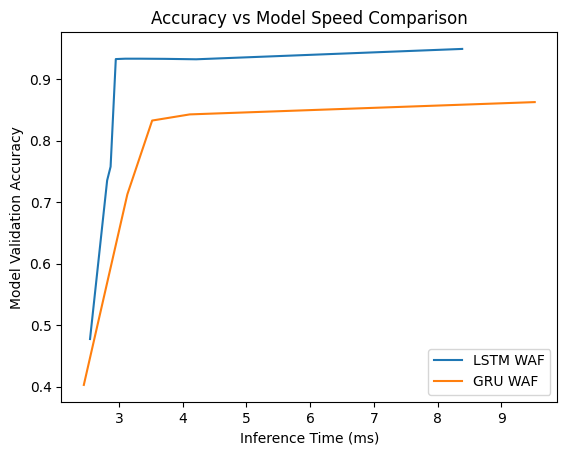

In [117]:
import matplotlib.pyplot as plt

plt.plot(x,y, label='LSTM WAF')
plt.plot(x2,y2, label='GRU WAF')
plt.xlabel('Inference Time (ms)')
plt.ylabel('Model Validation Accuracy')
plt.title('Accuracy vs Model Speed Comparison')
plt.legend()
plt.show()